In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import tensorflow as tf

RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

In [3]:
plt.rcParams["figure.figsize"] = [12, 9]

In [4]:
filename = 'test_data.csv'
directory = ''
data = genfromtxt(directory + filename, delimiter='\n')

First we define number of classes that can represent values of this time series.

In [5]:
a, b = np.histogram(data, bins=30)

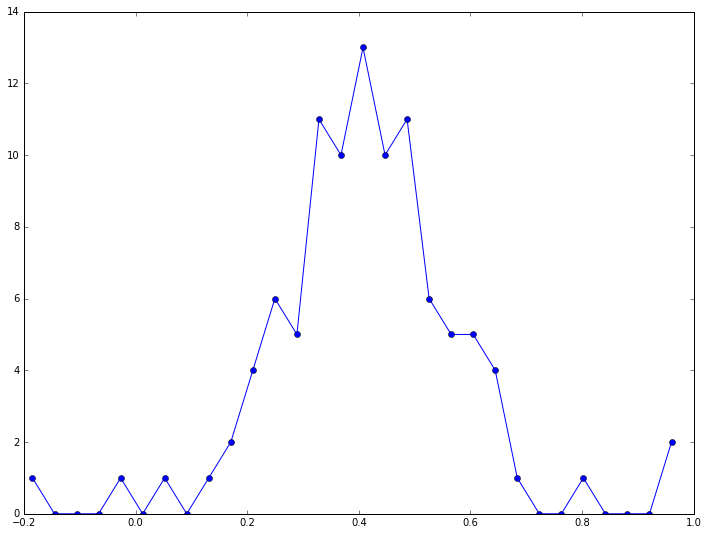

In [6]:
plot(b[:30], a, '-o')

Window size is a size of input signal

In [7]:
window_size = 7

In [8]:
values = []
for i in range(len(b)-1):
    if a[i] != 0:
        values.append(b[i])
values = np.asarray(values)

In [9]:
classes = []
for y in data[window_size:]:
    t = np.zeros(20)
    t[np.abs(values - y).argmin()] = 1
    classes.append(t)
classes = np.asarray(classes)

Cells below show MSE of this first approximation.

In [10]:
data2 = []
for d in data:
    data2.append(values[np.abs(values - d).argmin()])
data2 = np.asarray(data2)

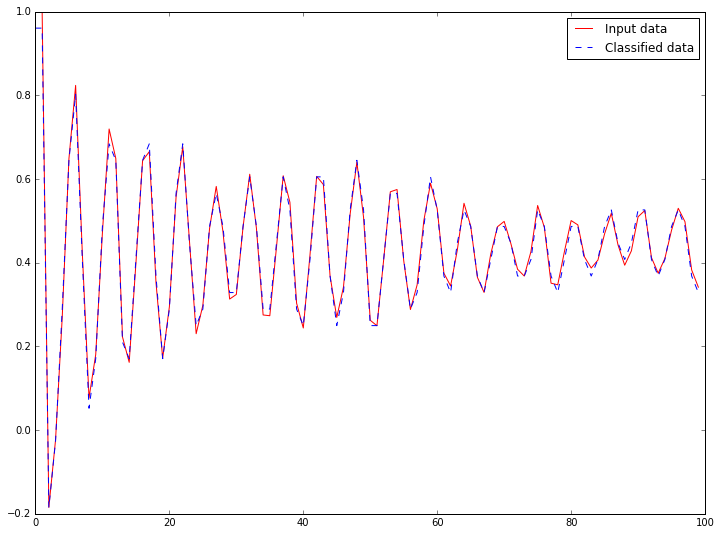

In [11]:
line1, = plt.plot(data, label='Input data', color='r')
line2, = plt.plot(data2, label='Classified data', linestyle='--')
plt.legend(handles=[line1, line2], loc=1)

In [12]:
mse_1st_appr = ((data - data2)**2).mean()
print mse_1st_appr

0.000176893023


For this investigation I divided data half by half (1st part is for training, 2nd - for testing)

In [13]:
inputs = []
for i in range(len(data) - window_size):
    inputs.append(data[0+i:window_size+i])

inputs = np.asarray(inputs)

In [14]:
train_x = np.asarray([item for (index, item) in enumerate(inputs) if (index + 1) % 2 != 0])
train_y = np.asarray([item for (index, item) in enumerate(classes) if (index + 1) % 2 != 0])
test_x = np.asarray([item for (index, item) in enumerate(inputs) if (index + 1) % 2 == 0])
test_y = np.asarray([item for (index, item) in enumerate(classes) if (index + 1) % 2 == 0])

Here below NN parameters:
 * 2 hidden layers
 * Input signal size is 7 (a window of 7  values)
 * 20 classes for output
 * Rectified linear for activation in hidden layers, linear for output

In [15]:
learning_rate = 0.001
training_epochs = 1000

#window_size = ... - size of input signal
n_hidden_1 = 1000 
n_hidden_2 = 100 
n_input = train_x.shape[1] 
n_classes = train_y.shape[1] 

x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

In [16]:
def forward_prop(x, weights, biases):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [17]:
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}


resp = forward_prop(x, weights, biases)
pred = tf.argmax(resp, dimension=1)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(resp, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

init = tf.initialize_all_variables()

saver = tf.train.Saver()

In [18]:
with tf.Session() as sess:
    sess.run(init)
    out_val = []
    min_mse = 0.1
    for epoch in range(training_epochs):
        #Training loop
        for i in range(len(test_x)):
            sess.run(optimizer, feed_dict={x: train_x[i: i + 1], y: train_y[i: i + 1]})
        #Checkings
        train_accuracy = np.mean(np.argmax(train_y, axis=1) ==
                                 sess.run(pred, feed_dict={x: train_x, y: train_y}))
        prediction = sess.run(pred, feed_dict={x: test_x, y: test_y})
        test_accuracy = np.mean(np.argmax(test_y, axis=1) == prediction)

        #Not the most optimal way to calcuate error
        
        predictions = []
        for i in range(len(test_y)):
            predictions.append(values[prediction[i]])
        predictions = np.asarray(predictions)
        
        test_data = []
        for i in range(len(test_y)):
            test_data.append(values[np.argmax(test_y[i])])
        test_data = np.asarray(test_data)
        
        mse = np.mean((predictions-test_data)**2)
        
        if mse < min_mse:
            min_mse = mse
            out_val = predictions
            saver.save(sess, 'network.ckpt')
        
        if epoch % 100 == 0 or epoch == training_epochs - 1:
            print("Epoch = %d, train accuracy = %.2f%%, test accuracy = %.2f%%, MSE = %.6f"
              % (epoch + 1, 100. * train_accuracy, 100. * test_accuracy, mse))
    print("Model saved for MSE = %.6f" % min_mse)

Epoch = 1, train accuracy = 4.26%, test accuracy = 4.35%, MSE = 0.059531
Epoch = 101, train accuracy = 74.47%, test accuracy = 28.26%, MSE = 0.003322
Epoch = 201, train accuracy = 82.98%, test accuracy = 34.78%, MSE = 0.003221
Epoch = 301, train accuracy = 93.62%, test accuracy = 39.13%, MSE = 0.002576
Epoch = 401, train accuracy = 91.49%, test accuracy = 32.61%, MSE = 0.003153
Epoch = 501, train accuracy = 93.62%, test accuracy = 43.48%, MSE = 0.002407
Epoch = 601, train accuracy = 65.96%, test accuracy = 26.09%, MSE = 0.005221
Epoch = 701, train accuracy = 97.87%, test accuracy = 43.48%, MSE = 0.002780
Epoch = 801, train accuracy = 97.87%, test accuracy = 43.48%, MSE = 0.002780
Epoch = 901, train accuracy = 95.74%, test accuracy = 32.61%, MSE = 0.002780
Epoch = 1000, train accuracy = 97.87%, test accuracy = 41.30%, MSE = 0.003017
Model saved for MSE = 0.001831


We failed with relative accuracy, but classes were chosen the way that let us have quite good MSE even if we add value of error of first approximation. Also the test represents a problem of a network retraining.

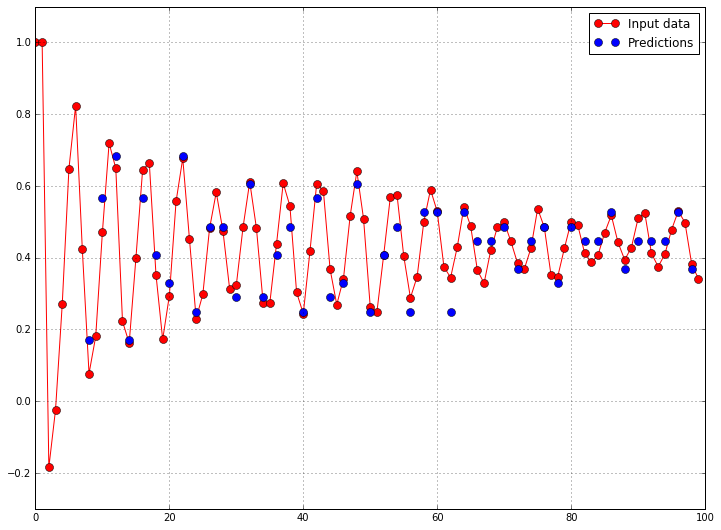

In [20]:
i, = plt.plot(range(100), data, label='Input data', color='r', marker='o', markersize=8)
indexes = [item for (index, item) in enumerate(range(window_size, len(data))) if (index + 1) % 2 == 0]
p, = plt.plot(indexes, out_val, 'bo', markersize=8, label='Predictions')
plt.axis([0, len(data), -0.3, 1.1])
plt.grid(True)
plt.legend(handles=[i, p], loc=1)